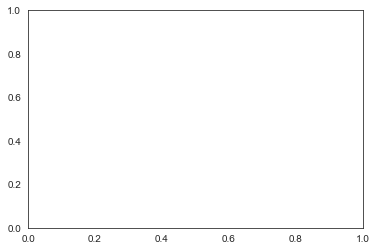

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import seaborn as sns
sns.set_style("white")
import numpy as np 
import pandas as pd 
from scipy import stats, integrate
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
from navipy.trajectories import Trajectory


# Get the drift during intersaccade and sumulation of pivoting:

During pivoting the yaw is expected to follow a uni directional rotation. Thus, by fitting a linear regression on each intersaccdic interval we can estimate the drift. The degree of drift is needed to estimate the location of the pivot point.

In this notebook after the drift angle is found and a perfect pivoting intersaccade is simulated

In [20]:
 head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5' 
# Load list of bees
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')

In [21]:
def linear_fit(x):
    '''linear fit on the interssacade yaw'''
    ##FIT THE LINEAR REGRESSION 
    time=x.index
    y=x.loc[:,('zyx','alpha_0')].astype(float) #yaw in radians
    slope, intercept, r_value, p_value, std_err = stats.linregress(time, y)
    drift=slope*len(time)
    
    return pd.Series({'drift': drift,
                      'slope':slope, 
                     'intercept':intercept, 
                     'r_value':r_value, 
                     'p_value':p_value, 
                     'std_err':std_err})

def simu_pivot(x):
    '''drifting yaw following a linear fit, and return pitch and roll averages during the interssacade'''
    time=x.index
    pivotparam = linear_fit(x)
    out_x = x.copy()
    out_x[('zyx','alpha_0')] = pivotparam.intercept + pivotparam.slope*time
    out_x[('zyx','alpha_1')] = x.loc[:,('zyx','alpha_1')].mean()
    out_x[('zyx','alpha_2')] = x.loc[:,('zyx','alpha_2')].mean()
    return out_x.astype(float)

# Example:

In [22]:
bee_ids = pd.read_hdf(head_filename_result,key='flight_ids')
beeid = '17'
assert beeid in bee_ids.values, 'Bee id unknwon'

blk_i = 0
key = '/blk_nonans/flight_{}'.format(beeid) 
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

assert blk_i in blknonans.index, 'Block unknown'

In [23]:
# Load the trajectory
key = '/trajectories/flight_{}/blk_{}'.format(beeid,blk_i) 
head_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
head_traj = Trajectory().from_dataframe(head_traj)
lamb = pd.Series(index=head_traj.columns, data=150)
head_traj.filt_cspline(lamb)
head_traj = head_traj.astype(float)
# Load the intersaccade 
key = '/res_sac/flight_{}/blk_{}'.format(beeid,blk_i) 
res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']

intersac_htraj = head_traj.loc[res_sac_head.intersac.dropna().index,:]
intersac_htraj['id_intersac'] = res_sac_head.intersac.dropna()
intersac_htraj.head()

location                             zyx                      \
              x          y          z   alpha_0   alpha_1   alpha_2   
337.0  8.840324 -55.978265  26.415362 -2.453275 -0.158637 -0.097742   
338.0  8.631195 -55.823916  26.350140 -2.454454 -0.162206 -0.099876   
339.0  8.349499 -55.606238  26.270804 -2.456198 -0.166602 -0.102817   
340.0  8.028865 -55.337747  26.198864 -2.458453 -0.171191 -0.106241   
341.0  7.697131 -55.030643  26.150214 -2.461282 -0.175634 -0.109832   

      id_intersac  
                   
337.0         0.0  
338.0         0.0  
339.0         0.0  
340.0         0.0  
341.0         0.0

In [24]:
transformed_htraj_intersac = intersac_htraj.groupby('id_intersac').apply(simu_pivot)
# Reindex as frame because grouping reindex in multiindex, but not necessary for us
transformed_htraj_intersac.index = transformed_htraj_intersac.index.get_level_values(level=1)
# We don't need the id of the inersaccade anymore
transformed_htraj_intersac.drop('id_intersac',inplace=True,axis=1)
# Saccade are untouched, so we copy
# and replace only the affected frames
transformed_htraj = head_traj.copy()
transformed_htraj.loc[transformed_htraj_intersac.index,:] = transformed_htraj_intersac.copy()

Text(0.5, 1.0, 'Constant drift head traj $f(T_h(t))$')

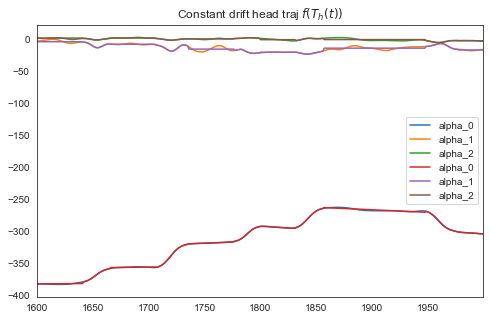

In [29]:
idx = np.arange(1600,2000)
fig,ax = plt.subplots(1,1,sharex=True,figsize=(8,5))

np.rad2deg(head_traj.loc[idx].zyx).plot(ax=ax)
np.rad2deg(transformed_htraj.loc[idx].zyx).plot(ax=ax)
ax.set_title('Constant drift head traj $f(T_h(t))$')




In [26]:
head_filename_simulated_motion = 'chapter_2_results/idealmotion.hdf'## path to save

In [6]:
# Loop through the flights
for flight_id in flight_ids:
    
    # Loop through the block
    key = '/blk_nonans/flight_{}'.format(flight_id)
    
    # Load block no nans for current bee
    blknonans = pd.read_hdf(head_filename_result_blocknonans, key)
    
    for blk_i, _ in blknonans.iterrows():

        key = '/trajectories_filtered/flight_{}/blk_{}'.format(flight_id,blk_i) 
        head_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']

        # Load the intersaccade 
        key = '/res_sac/flight_{}/blk_{}'.format(flight_id,blk_i) 
        res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']

        intersac_htraj = head_traj.loc[res_sac_head.intersac.dropna().index,:]
        #get index of the intersaccde
        intersac_htraj['id_intersac'] = res_sac_head.intersac.dropna()

        
        if intersac_htraj.shape[0]>0:
            
            # get linear fit parameter
            pivotparam = intersac_htraj.groupby('id_intersac').apply(linear_fit)
            
            # 1 transform in pivoting, apply param
            transformed_htraj_intersac = intersac_htraj.groupby('id_intersac').apply(simu_pivot)
            
            # Reindex as frame because grouping reindex in multiindex, but not necessary for us
            transformed_htraj_intersac.index = transformed_htraj_intersac.index.get_level_values(level=1)
            
            # We don't need the id of the intersaccde anymore
            transformed_htraj_intersac.drop('id_intersac',inplace=True,axis=1)
            # 2 - Recreate full traj
            # Saccade are untouched, so we copy and replace only the affected frames
            transformed_htraj = head_traj.copy()
            transformed_htraj.loc[transformed_htraj_intersac.index,:] = transformed_htraj_intersac.copy()
            
        else:
            pivotparam = pd.DataFrame(columns=['drift','slope','intercept','r_value','p_value','std_err'])
            transformed_htraj = head_traj.copy()
            
        
        # Save in hdf
        key = '/trajectories_constantdrift/flight_{}/blk_{}'.format(flight_id,blk_i)
        transformed_htraj.to_hdf(head_filename_simulated_motion, key=key)
        
        key = '/trajectories_constantdrift_param/flight_{}/blk_{}'.format(flight_id,blk_i)
        pivotparam.to_hdf(head_filename_simulated_motion, key=key)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalar

# Drift angle distribution

In [7]:
ALL_DRIFT=[]
data={}

for f in flight_ids:
    
    key = '/blk_nonans/flight_{}'.format(f) 
    blknonans = pd.read_hdf(head_filename_result_blocknonans,key)
    data[f]={}
    dic_block={}
    
    for b in blknonans.index:
        
        df=pd.read_hdf('chapter_2_results/idealmotion.hdf',key= '/trajectories_constantdrift_param/flight_{}/blk_{}'.format(f,b))
        
        dic_block[b]=df.loc[:,'drift']
    data[f]=pd.concat(dic_block)        
    
DF=pd.concat(data)            


DF.index.names = ['flight_i','blk_i','id_intersac']


-0.9560535557615115 7.044219930147885
NormaltestResult(statistic=232.9785770714289, pvalue=2.5665207989070224e-51)


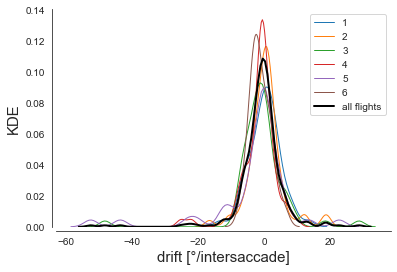

In [8]:
fig,ax=plt.subplots(1,1)
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b']
# Iterate through the five airlines
names_for_publi={'05':1,'06':2,'07':3,'08':4,'11':5,'17':6}
for flight_id,c in zip(flight_ids,colors):
    
    drift=DF.xs((flight_id),level=('flight_i'))
    drift=drift.dropna()
    drift*=180/np.pi
    sns.distplot(drift, hist = False,kde=True,kde_kws = {'linewidth': 1, "color": c},
             hist_kws={"histtype": "step", "linewidth": 1,
                  "alpha": 1, "color": c},label = names_for_publi[flight_id],ax=ax)
    
# Plot formatting
all_data=DF.dropna()*180/np.pi
sns.distplot(all_data, hist = False, kde = True,
             kde_kws = {'linewidth': 2,"color": 'k'},
              hist_kws={"histtype": "step", "linewidth": 3,
                      "alpha": 0.8, "color": "k"},
             label = 'all flights',color='k',ax=ax)
print(np.mean(all_data),np.std(all_data))
d=all_data.dropna().values.flatten().astype(float)
print(stats.normaltest(d))
lgd=ax.set_xlabel('drift [°/intersaccade]',fontsize=15)
ax.set_ylabel('KDE',fontsize=15)
sns.despine(offset=4)
#fig.savefig(fig_folder+'drift_distribution.png',dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
all_data.describe()


count    346.000000
mean      -0.956054
std        7.054422
min      -52.413514
25%       -3.177682
50%       -0.677697
75%        1.738322
max       28.574576
Name: drift, dtype: float64